In [1]:
import numpy as np
import gpmp.num as gnp
import gpmp as gp
import matplotlib.pyplot as plt

Using backend: torch


# Parameters

In [2]:
case_name           = "Hartmann4"
N_function_points   = 1000
N_observed_points   = 500
mu0                 = 0
p                   = 10
nugget              = 1e-12
meanparam           = np.array([mu0])

# Functions

In [3]:
def generate_data(case_name, N_function_points, N_observed_points):
    if   case_name == "Hartmann4":
        f   = gp.misc.testfunctions.hartmann4
        dim = 4
        box = [[0.0] * 4, [1.0] * 4]
    elif case_name == "Hartmann6":
        f   = gp.misc.testfunctions.hartmann6
        dim = 6
        box = [[0.0] * 6, [1.0] * 6]
    elif case_name == "Borehole":
        f   = gp.misc.testfunctions.borehole
        dim = 8
        box = [[0.05, 100., 63070., 990., 63.1, 700., 1120., 9855.], [0.15, 50000., 115600., 1110., 116., 820., 1680., 12045.]]
    elif case_name == "detpep8d":
        f   = gp.misc.testfunctions.detpep8d
        dim = 8
        box = [[0.0] * 8, [1.0] * 8]
    x_observed_points = gp.misc.designs.ldrandunif(dim, N_observed_points, box)
    x_function_points = gp.misc.designs.ldrandunif(dim, N_function_points, box)
    y_observed_points = f(x_observed_points)
    y_function_points = f(x_function_points)
    return x_function_points, y_function_points, x_observed_points, y_observed_points, box, dim

In [4]:
def constant_mean(x, meanparam):
    return meanparam[0] * gnp.ones((x.shape[0], 1))

In [5]:
def kernel(x, y, covparam, pairwise=False):
    return gp.kernel.maternp_covariance(x, y, p, covparam, pairwise, nugget)

In [6]:
def visualize_results(x_observed_points, y_observed_points, y_function_points, y_posterior_mean, case_name, box, dim):
    plt.figure()
    plt.plot(y_function_points, y_posterior_mean, "ko")
    (xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()
    xmin = min(xmin, ymin)
    xmax = max(xmax, ymax)
    plt.plot([xmin, xmax], [xmin, xmax], "--")
    plt.title(case_name)
    plt.show()
    yloom, yloov, eloo = model.loo(x_observed_points, y_observed_points)
    gp.misc.plotutils.plot_loo(y_observed_points, yloom, yloov)
    gp.misc.plotutils.crosssections(model, x_observed_points, y_observed_points, box, [0, 1], list(range(dim)))

# Points generation

In [7]:
x_function_points, y_function_points, x_observed_points, y_observed_points, box, dim = generate_data(case_name, N_function_points, N_observed_points)

# Gaussian process ND regression with GPMP

In [8]:
model                                  = gp.core.Model(constant_mean, kernel, meanparam, meantype="parameterized")
model, info                            = gp.kernel.select_parameters_with_reml(model, x_observed_points, y_observed_points, info=True)
covparam0                              = gp.kernel.anisotropic_parameters_initial_guess(model, x_observed_points, y_observed_points)
nlrl, dnlrl                            = gp.kernel.make_selection_criterion_with_gradient(model.negative_log_likelihood_zero_mean, x_observed_points, y_observed_points)
covparam_reml, info2                   = gp.kernel.autoselect_parameters(covparam0, nlrl, dnlrl, info=True)
model.covparam                         = gnp.asarray(covparam_reml)
y_posterior_mean, y_posterior_variance = model.predict(x_observed_points, y_observed_points, x_function_points)

In [9]:
print(np.exp(0.5*covparam_reml[0]))
for i in range(len(covparam_reml[1:])):
    print(np.exp(-covparam_reml[i+1]))

0.8991497190081702
0.45575379598238747
0.6031762772041409
0.5837381370927365
0.5453962482731535


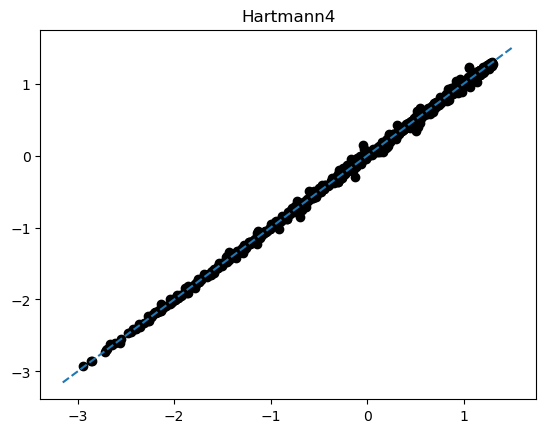

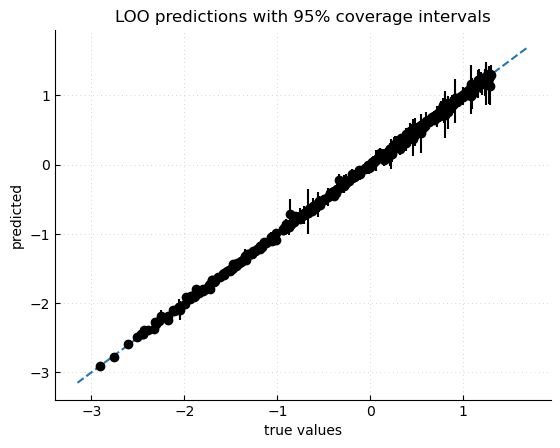

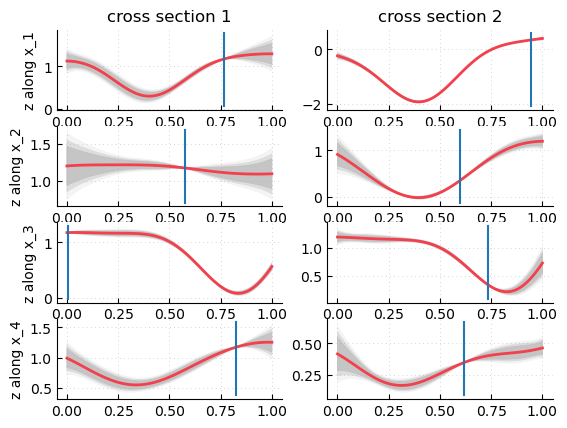

In [10]:
visualize_results(x_observed_points, y_observed_points, y_function_points, y_posterior_mean, case_name, box, dim)

# Gaussian process ND regression with custom class

In [11]:
import sys 
sys.path.append("C:/Users/L2S/Desktop/Efficient_and_reliable_GP/")

from Code.gaussian_processes.gaussian_process            import GaussianProcessModel
from Code.Parameters        .gaussian_process_parameters import gaussian_process_model_parameters

In [12]:
gaussian_process_model_parameters["Mean initialization method"] = "Fixed"
gaussian_process_model_parameters["Default mean parameter"    ] = mu0
gaussian_process_model_parameters["Nugget"                    ] = nugget
gaussian_process_model_parameters["Matern parameter"          ] = p

In [13]:
gaussian_process_model                 = GaussianProcessModel(x_observed_points, y_observed_points, gaussian_process_model_parameters)
gaussian_process_model.train()
hyperparameters                        = gaussian_process_model.get_hyperparameters() 
y_posterior_mean, y_posterior_variance = gaussian_process_model.predict(x_function_points)

In [14]:
hyperparameters

{'Time': 3.3442697525024414,
 'p': 10,
 'mu': 0,
 'sigma': 0.899149718558822,
 'Length scales': [0.45575379587488657,
  0.60317627694632,
  0.5837381366839312,
  0.5453962481496363],
 'Nugget': 1e-12}

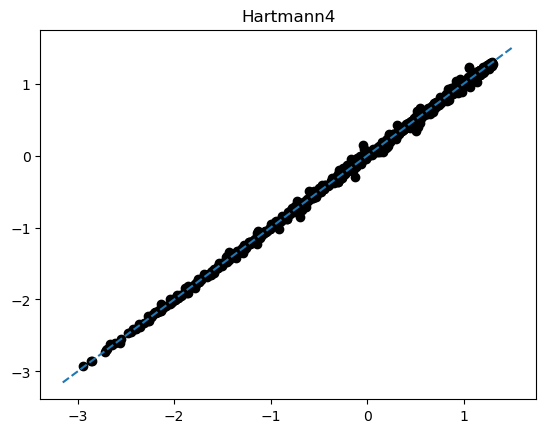

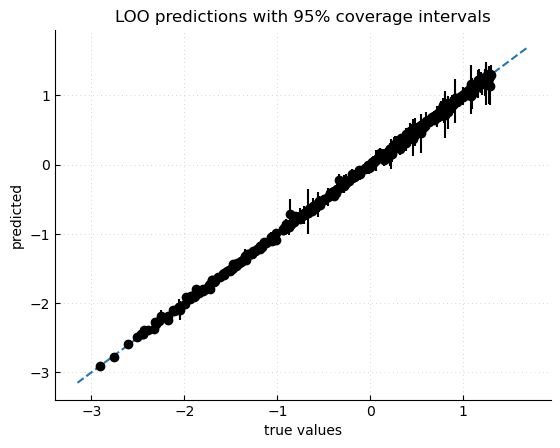

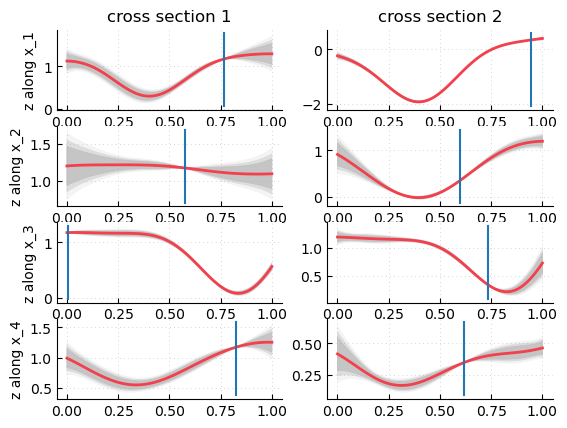

In [15]:
visualize_results(x_observed_points, y_observed_points, y_function_points, y_posterior_mean, case_name, box, dim)